# A notebook to show what the observations will look like in the EPPE rotating reference frame

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import EPPE_Simulator as eppe
import astropy.constants as const

In [2]:
expTime = 1./60. # exposure time in hours
intTime = 5. # integration time in hours
nPoints = int(np.rint(intTime/expTime))
rotPeriod = 1.6 # EPPE's rotation period
starPol = 0.75/100.

target = 'WASP-12 b'
# target = 'tau Boo b'

phoenixFolder = '/home/taylor/Documents/Research/PHOENIX/MedResFITS/R10000FITS/' # location where you want to save PHOENIX stellar models (default is './PHONEIX/MedResFITS/R10000FITS/')

albedo = 'theo'
polEff = 0.6
filt = 'EPPE'
randomOrientation = False

savePlots = False
savepath = 'saves/'

In [3]:
systems = eppe.Systems(load=True, polEff=polEff, randomOrientation=randomOrientation, albedo=albedo, phoenixFolder=phoenixFolder)
mission = eppe.mission(systems, filt=filt, trans=0.85, usePhoenix=True) # EPPE
_, fstars, _, _ = mission.observe_photometric(expTime, expTime, photonNoise=True, pStart=0)

In [4]:
F = fstars[np.where(systems.catalogue['name']==target)[0][0]]

In [5]:
nPhotons = F + np.random.normal(loc=0, scale=np.sqrt(F), size=nPoints)
nPhotons_stokes = np.random.normal(loc=0, scale=np.sqrt(F/3.)/2., 
                                   size=3*nPoints).reshape(3,nPoints)

stokesCurve = np.append(nPhotons[np.newaxis,:], nPhotons_stokes, axis=0)
stokesCurve[1] += F*starPol

In [6]:
stokesCurve_ideal = np.array([F, 0, 0, 0]).reshape(4,1)*np.ones(nPoints)
stokesCurve_ideal[1] += F*starPol

In [7]:
t = np.linspace(0,intTime,nPoints)
phis = ((t/rotPeriod+np.random.uniform())%1.)*360
stokesCurve = eppe.rotate(phis, stokesCurve)
stokesCurve_ideal = eppe.rotate(phis, stokesCurve_ideal)

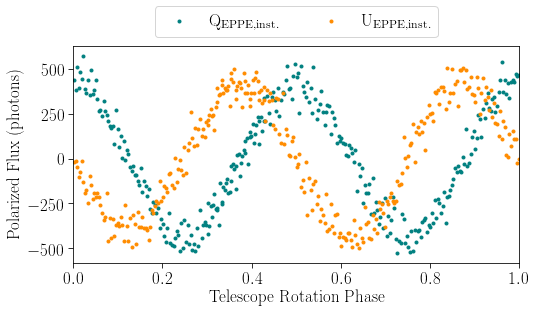

In [8]:
normed = False
plotIdeal = False
xTelPhase = True

fig, ax = plt.subplots(1, 1, figsize=(8,4))

if xTelPhase:
#     x = (phis%180)/180.
    x = (phis%360)/360.
    ax.set_xlim(0,1)
    xlabel = r'$\rm Telescope~Rotation~Phase$'
else:
    x = t
    xlabel = r'$\rm Time~(hours)$'
Q = np.copy(stokesCurve[1])
U = np.copy(stokesCurve[2])
if normed:
    Q /= stokesCurve[0]
    U /= stokesCurve[0]

order = np.argsort(x)
x = x[order]
Q = Q[order]
U = U[order]

if normed:
    Qlabel = 'q'
    Ulabel = 'u'
    norm = 1e6
else:
    Qlabel = 'Q'
    Ulabel = 'U'
    norm = 1.

ax.plot(x, Q*norm, '.', c='teal', label=r'$\rm '+Qlabel+'_{'+filt+',inst.}$')
ax.plot(x, U*norm, '.', c='darkorange', label=r'$\rm '+Ulabel+'_{'+filt+',inst.}$')

if plotIdeal:
    Q_ideal = np.copy(stokesCurve_ideal[1])
    U_ideal = np.copy(stokesCurve_ideal[2])
    
    if normed:
        Q_ideal /= stokesCurve_ideal[0]
        U_ideal /= stokesCurve_ideal[0]

    ax.plot(x, Q_ideal[order]*norm, '--', c='teal', label=r'$\rm '+Qlabel+'_{'+filt+',ideal,inst.}$')
    ax.plot(x, U_ideal[order]*norm, '--', c='darkorange', label=r'$\rm '+Ulabel+'_{'+filt+',ideal,inst.}$')

if normed:
    ylabel = r'$\rm Normalized~Polarized~Flux~(ppm)$'
else:
    ylabel = r'$\rm Polarized~Flux~(photons)$'
    
ax.set_ylabel(ylabel)
ax.set_xlabel(xlabel)
ax.legend(loc=8, bbox_to_anchor=(0.5,1), ncol=2)

if savePlots:
    fname = savepath+'observing_sequence_'+'_'.join(target.split(' '))+'.png'
    fig.savefig(fname, dpi=300, bbox_inches='tight')

plt.show()

plt.close(fig)